## テキストデータの前処理
コーパスとして青空文庫の「怪人二十面相」を使う  
テキストデータに前処理お行う

In [1]:
import re

with open("../books/kaijin_nijumenso.txt", mode="r", encoding="utf-8") as f:  # ファイルの読み込み
    text_original = f.read()

text = re.sub("《[^》]+》", "", text_original) # ルビの削除
text = re.sub("［[^］]+］", "", text) # 読みの注意の削除
text = re.sub("[｜ 　]", "", text) # | と全角半角スペースの削除
print("文字数", len(text))  # len() で文字列の文字数も取得可能

文字数 110323


In [2]:
n_rnn = 10  # 時系列の数
batch_size = 128
epochs = 60
n_mid = 128  # 中間層のニューロン数

## 文字のベクトル化
各文字をone-hot表現で表し、時系列の入力データおよび正解データを作成  
今回はRNNの最後の時刻の出力のみ利用するので、最後の出力に対応する正解のみ必要

In [4]:
import numpy as np

# インデックスと文字で辞書を作成
chars = sorted(list(set(text)))  # setで文字の重複をなくし、各文字をリストに格納する
print("文字数（重複無し）", len(chars))
char_indices = {}  # 文字がキーでインデックスが値
for i, char in enumerate(chars):
    char_indices[char] = i
indices_char = {}  # インデックスがキーで文字が値
for i, char in enumerate(chars):
    indices_char[i] = char
 
# 時系列データと、それから予測すべき文字を取り出します
time_chars = []
next_chars = []
for i in range(0, len(text) - n_rnn):
    time_chars.append(text[i: i + n_rnn])
    next_chars.append(text[i + n_rnn])
 
# 入力と正解をone-hot表現で表します
x = np.zeros((len(time_chars), n_rnn, len(chars)), dtype=np.bool)
t = np.zeros((len(time_chars), len(chars)), dtype=np.bool)
for i, t_cs in enumerate(time_chars):
    t[i, char_indices[next_chars[i]]] = 1  # 正解をone-hot表現で表す
    for j, char in enumerate(t_cs):
        x[i, j, char_indices[char]] = 1  # 入力をone-hot表現で表す
        
print("xの形状", x.shape)
print("tの形状", t.shape)

文字数（重複無し） 1249
xの形状 (110313, 10, 1249)
tの形状 (110313, 1249)


## モデルの構築
KerasのSimpleRNN層を使ってモデルを構築

In [5]:
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN

model = Sequential()
model.add(SimpleRNN(n_mid, input_shape=(n_rnn, len(chars))))
model.add(Dense(len(chars), activation="softmax"))
model.compile(loss='categorical_crossentropy', optimizer="adam")
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 128)               176384    
_________________________________________________________________
dense (Dense)                (None, 1249)              161121    
Total params: 337,505
Trainable params: 337,505
Non-trainable params: 0
_________________________________________________________________
None
2021-07-12 15:04:34.127082: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [8]:
from keras.callbacks import LambdaCallback
 
def on_epoch_end(epoch, logs):
    print("エポック: ", epoch)

    beta = 5  # 確率分布を調整する定数
    prev_text = text[0:n_rnn]  # 入力に使う文字
    created_text = prev_text  # 生成されるテキスト
    
    print("シード: ", created_text)

    for i in range(400):
        # 入力をone-hot表現に
        x_pred = np.zeros((1, n_rnn, len(chars)))
        for j, char in enumerate(prev_text):
            x_pred[0, j, char_indices[char]] = 1
        
        # 予測を行い、次の文字を得る
        y = model.predict(x_pred)
        p_power = y[0] ** beta  # 確率分布の調整
        next_index = np.random.choice(len(p_power), p=p_power/np.sum(p_power))        
        next_char = indices_char[next_index]

        created_text += next_char
        prev_text = prev_text[1:] + next_char

    print(created_text)
    print()

# エポック終了後に実行される関数を設定
epock_end_callback= LambdaCallback(on_epoch_end=on_epoch_end)

In [9]:
history = model.fit(x, t,
                    batch_size=batch_size,
                    epochs=epochs,
                    callbacks=[epock_end_callback])

と、門内には、そのうとう一度もあるんです。それから、それをは、これから、そのおかえ、二十面相の人から、あまわりを見まったのです。
それで、その男は、このおとうさながら、いっかりのほんでも、その冒険はないっというのです。
「ああ、あ、そうなくば、いう

Epoch 23/60
862/862 [==============================] - 27s 32ms/step - loss: 2.1464
エポック:  22
シード:  そのころ、東京中の町
そのころ、東京中の町という町のかとりを出ていました。
「ハハハ……、どうして、明智小五郎の住みの中に、もっとしたら、ぼくは少しもありません。
「このができたいえます。
「ウン、明智探偵は、そのうちがいていきました。
「ハハハ……、どうして、おそろしいになりました。
「ウン、おまえているのです。
「おと、さえ、そのからいつのました。
「おや、さすが、明智小五郎のかったのです。
「おや、さすが、明智小五郎のかったいど、すぐらいの名画を、あげんなことを考えていたのです。
「ことは、きみなんというのです。
「おとうさんだよ。」
「どうして、明智小五郎の住宅で、女のさんの棚の中には、あっかにしたべていると、そうしたがあ、ことものですから、もうものですから、この奇妙な取り番をしろしためて、しまいくなっていたのです。
「おと、明智君は、きみのさいぜつのことには、きました。
して、そのうえ、このかえにはなかったのです。
「お

Epoch 24/60
862/862 [==============================] - 27s 32ms/step - loss: 2.1200
エポック:  23
シード:  そのころ、東京中の町
そのころ、東京中の町という町の家という貴重な品物を、することにしているのです。
「ここでも、もわかには、きょうぶじことです。
「ああ、こんなんだ。」
「であ、このことは、この二十面相は、こんなには、こんなふとりことがありました。
「二十面相は、こんなには、こんなふとりことでする。そのうち、それを見ますと、にぎりかけにして、チラチラと見えているのです。
「ここで？ああ、こんなんか。」
「それは、どんなことはありません。
「二十面相は、こんなには、こんなふとりことがありました。


## 学習の推移


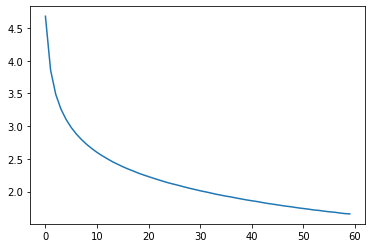

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss)
plt.show()